# Mortgage Lending

## I. Introduction
Being a homeowner has been long considered the American Dream. However, that dream comes with great costs known as mortgages. Applying for a mortgage can be a lengthy and cumbersome process. It is both mentally and financially taxing for the applicant. Furthermore, regardless of the outcome, people are obligated to pay mortgage application fees and potentially additional fees throughout the process. The goal of this project is to utilize a machine learning algorithm to predict whether a mortgage application will get approved or denied. This algorithm can save users time and money during the application process.

## II. Data

The Home Mortgage Disclosure Act (or HMDA) of 1975 requires certain financial institutions to provide mortgage data to the public. These financial institutions range from top banks to local ones as well as mortgage companies. Every year, HMDA reports on mortgage decisions and various other features of the applications. I used HMDA data from 2019 to see whether I can build a machine learning algorithm to predict mortgage approval or denial as outcomes. My focus was on mortgage applications for home purchases for principal homes. Furthermore, for the purposes of practicality, I limited my data to mortgage applications submitted to Bank of America (BOA from onwards). The data has information on 1) applicants' demographics, 2) loan properties, 3) house characteristics.



## III. Methodology
### 1. Data Preprocessing

In [3]:
#first let's import the necessary libraries
import os
print(os.getcwd())
import io
import requests, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats
import eli5

#figures inline
%matplotlib inline

/Users/eylul/Repo/Projects


In [4]:
#get the data file for BOA and read
BOA_URL = 'https://s3.amazonaws.com/cfpb-hmda-public/prod/modified-lar/2019/header/B4TYDEB6GKMZO031MB27_header.txt'
BOA_data = pd.read_csv(BOA_URL, sep = '|')
print("The shape of the BOA datatset is {}".format(BOA_data.shape))

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (73) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The shape of the BOA datatset is (466552, 85)


In [5]:
pd.set_option('display.max_columns', None)
BOA_data.head()

,Record Identifier,Legal Entity Identifier (LEI),Loan Type,Loan Purpose,Preapproval,Construction Method,Occupancy Type,Loan Amount,Action Taken,State,County,Census Tract,Ethnicity of Applicant or Borrower: 1,Ethnicity of Applicant or Borrower: 2,Ethnicity of Applicant or Borrower: 3,Ethnicity of Applicant or Borrower: 4,Ethnicity of Applicant or Borrower: 5,Ethnicity of Co-Applicant or Co-Borrower: 1,Ethnicity of Co-Applicant or Co-Borrower: 2,Ethnicity of Co-Applicant or Co-Borrower: 3,Ethnicity of Co-Applicant or Co-Borrower: 4,Ethnicity of Co-Applicant or Co-Borrower: 5,Ethnicity of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Ethnicity of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Race of Applicant or Borrower: 1,Race of Applicant or Borrower: 2,Race of Applicant or Borrower: 3,Race of Applicant or Borrower: 4,Race of Applicant or Borrower: 5,Race of Co-Applicant or Co-Borrower: 1,Race of Co-Applicant or Co-Borrower: 2,Race of Co-Applicant or Co-Borrower: 3,Race of Co-Applicant or Co-Borrower: 4,Race of Co-Applicant or Co-Borrower: 5,Race of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Race of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Sex of Applicant or Borrower,Sex of Co-Applicant or Co-Borrower,Sex of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Sex of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Age of Applicant or Borrower,Age of Applicant >= 62,Age of Co-Applicant or Co-Borrower,Age of Co-Applicant >= 62,Income,Type of Purchaser,Rate Spread,HOEPA Status,Lien Status,Applicant or Borrower - Name and Version of Credit Scoring Model,Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model,Reason for Denial: 1,Reason for Denial: 2,Reason for Denial: 3,Reason for Denial: 4,Total Loan Costs,Total Points and Fees,Origination Charges,Discount Points,Lender Credits,Interest Rate,Prepayment Penalty Term,Debt-to-Income Ratio,Combined Loan-to-Value Ratio,Loan Term,Introductory Rate Period,Balloon Payment,Interest-Only Payments,Negative Amortization,Other Non-Amortizing Features,Property Value,Manufactured Home Secured Property Type,Manufactured Home Land Property Interest,Total Units,Multifamily Affordable Units,Submission of Application,Initially Payable to Your Institution,Automated Underwriting System: 1,Automated Underwriting System: 2,Automated Underwriting System: 3,Automated Underwriting System: 4,Automated Underwriting System: 5,Reverse Mortgage,Open-End Line of Credit,Business or Commercial Purpose
0,2,B4TYDEB6GKMZO031MB27,3,5,2,1,3,165000,6,AL,1081.0,1.081042e+09,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3,3,7.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,3,3,4,4,3,3,8888,NaN,8888,NaN,NaN,0,NaN,3,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.750,NaN,NaN,NaN,360.0,NaN,2,2,2,2,NaN,3,5,1,NaN,3,3,6,NaN,NaN,NaN,NaN,2,2,1
1,2,B4TYDEB6GKMZO031MB27,2,5,2,1,1,95000,6,AZ,4019.0,4.019003e+09,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3,3,7.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,3,3,4,4,3,3,8888,NaN,8888,NaN,NaN,0,NaN,3,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.875,NaN,NaN,NaN,360.0,NaN,2,2,2,2,NaN,3,5,1,NaN,3,3,6,NaN,NaN,NaN,NaN,2,2,2
2,2,B4TYDEB6GKMZO031MB27,2,5,2,1,1,215000,6,NY,36081.0,3.608102e+10,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3,3,7.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,3,3,4,4,3,3,8888,NaN,8888,NaN,87.0,2,NaN,3,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.250,NaN,NaN,NaN,360.0,NaN,2,2,2,2,NaN,3,5,1,NaN,3,3,6,NaN,NaN,NaN,NaN,2,2,2
3,2,B4TYDEB6GKMZO031MB27,3,5,2,1,1,285000,6,MD,24017.0,2.401785e+10,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3,3,7.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,3,3,4,4,3,3,8888,NaN,8888,NaN,NaN,0,NaN,3,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.500,NaN,NaN,NaN,360.0,NaN,2,2,2,2,NaN,3,5,1,NaN,3,3,6,NaN,NaN,NaN,NaN,2,2,2
4,2,B4TYDEB6GKMZO031MB27,3,5,2,1,3,125000,6,KY,21163.0,2.116397e+10

This data looks messy with a lot of missing values. We have 85 columns but some of them are not informative.

### 1.1 Filter the dataset to include home purchases of primary homes for approved and denied mortgages

In [6]:
#create the dataset of interest
BOA_data = BOA_data[(BOA_data['Loan Purpose'] == 1) & (BOA_data['Occupancy Type'] == 1) & ((BOA_data['Action Taken'] == 1) | (BOA_data['Action Taken'] == 3) | (BOA_data['Action Taken'] == 2))]
#BOA_data['Action Taken'].value_counts()
#BOA_data['Occupancy Type'].value_counts()
#BOA_data['Loan Purpose'].value_counts()
print("The shape of the BOA datatset is {}".format(BOA_data.shape))

The shape of the BOA datatset is (82267, 85)


### 1.2 Drop columns with 80% or more missing values and columns with one value

In [7]:
#check data for missing values
#pd.set_option('display.max_rows', None)
BOA_data.isna().sum()

Record Identifier                       0
Legal Entity Identifier (LEI)           0
Loan Type                               0
Loan Purpose                            0
Preapproval                             0
                                    ...  
Automated Underwriting System: 4    82267
Automated Underwriting System: 5    82267
Reverse Mortgage                        0
Open-End Line of Credit                 0
Business or Commercial Purpose          0
Length: 85, dtype: int64

In [8]:
#write a function to drop missing columns with X percentage or more missing data
def na_detection(data, percentage):
    for col in data:
        na_proportion = data[col].isna().sum()/len(data[col])
        if na_proportion.round(2) >= percentage:
            data.drop(col, axis = 1, inplace = True)
            
na_detection(BOA_data, .80)
print("The shape of the BOA datatset is {}".format(BOA_data.shape))

The shape of the BOA datatset is (82267, 59)


In [9]:
#check to see whether it worked
BOA_data.isna().sum()

Record Identifier                                                                                       0
Legal Entity Identifier (LEI)                                                                           0
Loan Type                                                                                               0
Loan Purpose                                                                                            0
Preapproval                                                                                             0
Construction Method                                                                                     0
Occupancy Type                                                                                          0
Loan Amount                                                                                             0
Action Taken                                                                                            0
State                                         

In [10]:
# write a function that removes columns that only have one value because they are not informative
def unique_count(data):
    for col in data:
        if data[col].nunique() == 1:
            data.drop(col, axis = 1, inplace = True)

unique_count(BOA_data)

In [11]:
#check
print("The shape of the BOA datatset is {}".format(BOA_data.shape))

The shape of the BOA datatset is (82267, 52)


### 1.3 Examine whether there are conditional features 
Some features are only used/filled after a certain approval decision. For instance, reason for denial is only for denied decisions. To test for this, I divided my dataset into two datasets, approved and denied mortgages, and checked for the missing values again.

In [12]:
#create the separate datasets for approval and denial decisions
Denied = BOA_data[BOA_data['Action Taken'] == 3]
Approved = BOA_data[BOA_data['Action Taken'] != 3]

In [13]:
#write a function that returns the names of columns with 80% or more missing data
def na_cols(data, percentage):
    col_names = []
    for col in data:
        na_proportion = data[col].isna().sum()/len(data[col])
        if na_proportion.round(2) >= percentage:
            col_names.append(col)
    return col_names

In [14]:
col_names = na_cols(Denied, .80)
#there are some columns with missing data for denied applicants
col_names

['Rate Spread',
 'Total Loan Costs',
 'Origination Charges',
 'Discount Points',
 'Lender Credits',
 'Interest Rate',
 'Automated Underwriting System: 2']

Looking at these columns from HMDA glossary and reporting schema, these are specific for approved applications, and thus are not informative for us.

In [15]:
na_cols(Approved, .80)
#there are no columns with 80% or more missing data for approved applicants

[]

In [16]:
#dropping the uninformative columns
BOA_data.drop(col_names, axis = 1, inplace = True)
print("The shape of the BOA datatset is {}".format(BOA_data.shape))

The shape of the BOA datatset is (82267, 45)


### 1.4 Filter based on domain knowledge regarding each feature
Some of the columns in the dataset were not relevant for mortgage approval or are redundant. I aimed to identify uninformative variables. All of the features were considered individually. Below only problematic features are reported for practical purposes:  
1) County and Census Tract: These might not be that informative given that there are many categories under these and not enough data points coming from a particular geographic location.  
2) Ethnicity of Applicant or Borrower Collected on the Basis of Visual Observation or Surname: This is not informative. The same applies to the features, Race of Applicant or Borrower Collected on the Basis of Visual Observation or Surname and Sex of Applicant or Borrower Collected on the Basis of Visual Observation or Surname, as well as co-applicants.  
3) Age of Applicant >= 62: This is redundant with age. The same applies to the feature, Age of Co-Applicant >= 62.  
4) Type of Purchaser: Type of entity that purchased the loan. This is not relevant for the project.   
5) Applicant or Borrower - Name and Version of Credit Scoring Model: This is not informative. The same applies to the feature, Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model'.  
6) Reason for Denial: Only applicable to denied loans.   
7) Automated Underwriting System: 1: This is not informative.  

The knowledge regarding the features are collected from:
* https://github.com/cfpb/hmda-platform/blob/master/docs/v2/spec/Modified%20LAR%20Schema.csv
* https://ffiec.gov/hmda/glossary.htm#C
* https://www.ffiec.gov/hmda/pdf/2018guide.pdf
* https://files.consumerfinance.gov/f/documents/cfpb_new-revised-data-points-in-hmda_report.pdf

In [17]:
#based on domain knowledge drop redundant or uninformative columns
BOA_data.drop(BOA_data.columns[[6,7,10,11,14,15,18,19,21,23,25,28,29,30,42]], axis = 1, inplace = True) 
print("The shape of the BOA datatset is {}".format(BOA_data.shape))

The shape of the BOA datatset is (82267, 30)


### 1.5 Reogranize data: Fix column names
The column names are not analysis friendly and they are quite wordy and long. Let's fix that:

In [18]:
# a function that removes indicated substrings from column names and replaces ' ' with '_'
def clean_col_names(data, string):
    for i in string:
        for col in data:
             data.rename(columns = lambda col: col.replace(i, ''), inplace = True)
    data.rename(columns = lambda col: col.replace(' ', '_'), inplace = True)
    data.rename(columns = str.lower, inplace = True)
#apply to our dataset
string = [' or Borrower: 1', ' or Borrower', ' or Co-Borrower: 1', ' or Co-Borrower']
clean_col_names(BOA_data, string)

In [19]:
#check
BOA_data.head()

,loan_type,preapproval,construction_method,loan_amount,action_taken,state,ethnicity_of_applicant,ethnicity_of_co-applicant,race_of_applicant,race_of_co-applicant,sex_of_applicant,sex_of_co-applicant,age_of_applicant,age_of_co-applicant,income,hoepa_status,lien_status,debt-to-income_ratio,combined_loan-to-value_ratio,loan_term,balloon_payment,interest-only_payments,negative_amortization,property_value,manufactured_home_secured_property_type,manufactured_home_land_property_interest,total_units,submission_of_application,open-end_line_of_credit,business_or_commercial_purpose
8,1,1,1,115000,1,NV,2.0,5.0,5.0,8.0,1,5,45-54,9999,30.0,2,1,38,80.00,360.0,2,2,2,145000.0,3,5,1,1,2,2
9,1,2,1,615000,1,MN,2.0,5.0,5.0,8.0,1,5,25-34,9999,224.0,2,1,30%-<36%,80.00,360.0,2,2,2,765000.0,3,5,1,1,2,2
14,1,2,1,405000,1,OR,2.0,2.0,2.0,2.0,2,1,35-44,35-44,87.0,2,1,39,95.00,360.0,2,2,2,425000.0,3,5,1,1,2,2
15,1,1,1,2805000,1,CA,2.0,5.0,5.0,8.0,1,5,45-54,9999,1922.0,2,1,20%-<30%,63.75,360.0,2,2,2,4405000.0,3,5,1,1,2,2
17,2,2,1,265000,1,FL,2.0,2.0,5.0,5.0,2,1,25-34,25-34,NaN,2,1,36,96.50,360.0,2,2,2,265000.0,3,5,1,1,2,2


Looks much nicer! Some are still wordy but not as much. 

### 1.6 Reorganize data: Coding schema
1) Let's regroup ethnicity and race features into bigger bins because some categories have sub-categories. 

In [20]:
#demonstrate the problem
BOA_data['race_of_applicant'].value_counts()

5.0     45007
6.0     15100
2.0     12249
3.0      6493
21.0     1827
1.0       460
22.0      294
27.0      223
23.0      136
26.0      104
25.0       98
4.0        86
7.0        71
44.0       63
24.0       21
41.0        5
42.0        2
43.0        2
Name: race_of_applicant, dtype: int64

In [21]:
#write a function to fix the problem
def regroup(data,col_names):
    for col in col_names:
        data[col] = [row//10 if row >10 else row for row in data[col]]

#apply the function to the dataset
col_names = ['ethnicity_of_applicant',  'ethnicity_of_co-applicant', 'race_of_applicant','race_of_co-applicant']        
regroup(BOA_data, col_names)

In [22]:
#check whether the function worked
BOA_data['race_of_applicant'].value_counts()

5.0    45007
6.0    15100
2.0    14952
3.0     6493
1.0      460
4.0      158
7.0       71
Name: race_of_applicant, dtype: int64

2) Let's look at the data types and fix them if they are wrong.

In [23]:
BOA_data.dtypes

loan_type                                     int64
preapproval                                   int64
construction_method                           int64
loan_amount                                   int64
action_taken                                  int64
state                                        object
ethnicity_of_applicant                      float64
ethnicity_of_co-applicant                   float64
race_of_applicant                           float64
race_of_co-applicant                        float64
sex_of_applicant                              int64
sex_of_co-applicant                           int64
age_of_applicant                             object
age_of_co-applicant                          object
income                                      float64
hoepa_status                                  int64
lien_status                                   int64
debt-to-income_ratio                         object
combined_loan-to-value_ratio                float64
loan_term   

These are quite wrong. Let's fix each variable based on the coding and let's make them categorical variables.

In [24]:
#reorganize
pd.set_option('mode.chained_assignment', None)

#Loan Type
BOA_data['loan_type'][BOA_data['loan_type'] == 1] = 'conventional'
BOA_data['loan_type'][BOA_data['loan_type'] == 2] = 'federal'
BOA_data['loan_type'][BOA_data['loan_type'] == 3] = 'veterans'
BOA_data['loan_type'][BOA_data['loan_type'] == 4] = 'rural'

#Preapproval
BOA_data['preapproval'][BOA_data['preapproval'] == 1] = 'requested'
BOA_data['preapproval'][BOA_data['preapproval'] == 2] = 'not requested'

#Construction method
BOA_data['construction_method'][BOA_data['construction_method'] == 1] = 'site-built'
BOA_data['construction_method'][BOA_data['construction_method'] == 2] = 'manufactured home'

#Action taken
BOA_data['action_taken'][(BOA_data['action_taken'] == 1) | (BOA_data['action_taken'] == 2)] = 'approved'
BOA_data['action_taken'][BOA_data['action_taken'] == 3] = 'denied'

#Ethnicity of applicant
BOA_data['ethnicity_of_applicant'][BOA_data['ethnicity_of_applicant'] == 1] = 'Hispanic or Latinx'
BOA_data['ethnicity_of_applicant'][BOA_data['ethnicity_of_applicant'] == 2] = 'Not Hispanic or Latinx'
BOA_data['ethnicity_of_applicant'][BOA_data['ethnicity_of_applicant'] == 3] = 'Not reported'
BOA_data['ethnicity_of_applicant'][BOA_data['ethnicity_of_applicant'] == 4] = np.nan

#Ethnicity of co-applicant
BOA_data['ethnicity_of_co-applicant'][BOA_data['ethnicity_of_co-applicant'] == 1] = 'Hispanic or Latinx'
BOA_data['ethnicity_of_co-applicant'][BOA_data['ethnicity_of_co-applicant'] == 2] = 'Not Hispanic or Latinx'
BOA_data['ethnicity_of_co-applicant'][BOA_data['ethnicity_of_co-applicant'] == 3] = 'Not reported'
BOA_data['ethnicity_of_co-applicant'][BOA_data['ethnicity_of_co-applicant']== 4] = np.nan
BOA_data['ethnicity_of_co-applicant'][BOA_data['ethnicity_of_co-applicant']== 5] = 'No co-applicant'

#Race of applicant
BOA_data['race_of_applicant'][BOA_data['race_of_applicant']== 1] = 'Native American'
BOA_data['race_of_applicant'][BOA_data['race_of_applicant'] == 2] = 'Asian'
BOA_data['race_of_applicant'][BOA_data['race_of_applicant'] == 3] = 'Black or African American'
BOA_data['race_of_applicant'][BOA_data['race_of_applicant']== 4] = 'Pacific Islander'
BOA_data['race_of_applicant'][BOA_data['race_of_applicant']== 5] = 'White'
BOA_data['race_of_applicant'][BOA_data['race_of_applicant']== 6] = 'Not reported'
BOA_data['race_of_applicant'][BOA_data['race_of_applicant']== 7] = np.nan

#Race of co-applicant
BOA_data['race_of_co-applicant'][BOA_data['race_of_co-applicant']== 1] = 'Native American'
BOA_data['race_of_co-applicant'][BOA_data['race_of_co-applicant'] == 2] = 'Asian'
BOA_data['race_of_co-applicant'][BOA_data['race_of_co-applicant']== 3] = 'Black or African American'
BOA_data['race_of_co-applicant'][BOA_data['race_of_co-applicant']== 4] = 'Pacific Islander'
BOA_data['race_of_co-applicant'][BOA_data['race_of_co-applicant']== 5] = 'White'
BOA_data['race_of_co-applicant'][BOA_data['race_of_co-applicant']== 6] = 'Not reported'
BOA_data['race_of_co-applicant'][BOA_data['race_of_co-applicant']== 7] = np.nan
BOA_data['race_of_co-applicant'][BOA_data['race_of_co-applicant']== 8] = 'No co-applicant'

#Sex of applicant
BOA_data['sex_of_applicant'][BOA_data['sex_of_applicant'] == 1] = 'male'
BOA_data['sex_of_applicant'][BOA_data['sex_of_applicant']  == 2] = 'female'
BOA_data['sex_of_applicant'][BOA_data['sex_of_applicant']  == 3] = 'Not reported'
BOA_data['sex_of_applicant'][BOA_data['sex_of_applicant']  == 4] = np.nan
BOA_data['sex_of_applicant'][BOA_data['sex_of_applicant'] == 6] = 'both'

#Sex of co-applicant
BOA_data['sex_of_co-applicant'][BOA_data['sex_of_co-applicant'] == 1] = 'male'
BOA_data['sex_of_co-applicant'][BOA_data['sex_of_co-applicant'] == 2] = 'female'
BOA_data['sex_of_co-applicant'][BOA_data['sex_of_co-applicant'] == 3] = 'Not reported'
BOA_data['sex_of_co-applicant'][BOA_data['sex_of_co-applicant'] == 4]= np.nan
BOA_data['sex_of_co-applicant'][BOA_data['sex_of_co-applicant'] == 5]= 'No co-applicant'
BOA_data['sex_of_co-applicant'][BOA_data['sex_of_co-applicant'] == 6] = 'both'

#Age of applicant
BOA_data['age_of_applicant'][BOA_data['age_of_applicant']  == '8888'] = np.nan
BOA_data['age_of_applicant']= BOA_data['age_of_applicant'].astype('object')

#Age of co-applicant
BOA_data['age_of_co-applicant'][BOA_data['age_of_co-applicant']  == '8888'] = np.nan
BOA_data['age_of_co-applicant'][BOA_data['age_of_co-applicant']  == '9999'] = 'No co-applicant'
BOA_data['age_of_co-applicant']= BOA_data['age_of_co-applicant'].astype('object')

#HOEPA status
BOA_data['hoepa_status'][BOA_data['hoepa_status']  == 1] = 'high cost' 
BOA_data['hoepa_status'][BOA_data['hoepa_status']  == 2] = 'not high cost'
BOA_data['hoepa_status'][BOA_data['hoepa_status']  == 3] = np.nan

#Lien status
BOA_data['lien_status'][BOA_data['lien_status']  == 1] = 'first' 
BOA_data['lien_status'][BOA_data['lien_status']  == 2] = 'subordinate'

#Debt-to-income ratio
BOA_data['debt-to-income_ratio'] = BOA_data['debt-to-income_ratio'].astype('object')
BOA_data['debt-to-income_ratio'][(BOA_data['debt-to-income_ratio'] > str(35)) & (BOA_data['debt-to-income_ratio']  < str(50))] = '36%-<50%'

#Balloon payment
BOA_data['balloon_payment'][BOA_data['balloon_payment']  == 1] = 'yes' 
BOA_data['balloon_payment'][BOA_data['balloon_payment']  == 2] = 'no'

#Interest-only payment
BOA_data['interest-only_payments'][BOA_data['interest-only_payments']  == 1] = 'yes' 
BOA_data['interest-only_payments'][BOA_data['interest-only_payments']  == 2] = 'no'

#Negative amortization
BOA_data['negative_amortization'][BOA_data['negative_amortization']  == 1] = 'yes' 
BOA_data['negative_amortization'][BOA_data['negative_amortization']  == 2] = 'no'

#Manufactured home secured property type
BOA_data['manufactured_home_secured_property_type'][BOA_data['manufactured_home_secured_property_type']  == 1] = 'home and land' 
BOA_data['manufactured_home_secured_property_type'][BOA_data['manufactured_home_secured_property_type']  == 2] = 'home not land'
BOA_data['manufactured_home_secured_property_type'][BOA_data['manufactured_home_secured_property_type']  == 3] = np.nan

#Manufactured home land secured property interest
BOA_data['manufactured_home_land_property_interest'][BOA_data['manufactured_home_land_property_interest']  == 1] = 'direct ownership' 
BOA_data['manufactured_home_land_property_interest'][BOA_data['manufactured_home_land_property_interest']  == 2] = 'indirect ownership'
BOA_data['manufactured_home_land_property_interest'][BOA_data['manufactured_home_land_property_interest']  == 3] = 'paid leasehold'
BOA_data['manufactured_home_land_property_interest'][BOA_data['manufactured_home_land_property_interest']  == 4] = 'unpaid leasehold'
BOA_data['manufactured_home_land_property_interest'][BOA_data['manufactured_home_land_property_interest']  == 5] = np.nan

#Total units
BOA_data['total_units'] = BOA_data['total_units'].astype('int64')

#Submission of application
BOA_data['submission_of_application'][BOA_data['submission_of_application']  == 1] = 'direct' 
BOA_data['submission_of_application'][BOA_data['submission_of_application']  == 2] = 'indirect'
BOA_data['submission_of_application'][BOA_data['submission_of_application']  == 3] = np.nan

#Open-end line of credit
BOA_data['open-end_line_of_credit'][BOA_data['open-end_line_of_credit']  == 1] = 'yes' 
BOA_data['open-end_line_of_credit'][BOA_data['open-end_line_of_credit']  == 2] = 'no'

#Business or commercial purpose
BOA_data['business_or_commercial_purpose'][BOA_data['business_or_commercial_purpose'] == 1] = 'yes' 
BOA_data['business_or_commercial_purpose'][BOA_data['business_or_commercial_purpose'] == 2] = 'no'
 

In [25]:
#check
BOA_data.dtypes

loan_type                                    object
preapproval                                  object
construction_method                          object
loan_amount                                   int64
action_taken                                 object
state                                        object
ethnicity_of_applicant                       object
ethnicity_of_co-applicant                    object
race_of_applicant                            object
race_of_co-applicant                         object
sex_of_applicant                             object
sex_of_co-applicant                          object
age_of_applicant                             object
age_of_co-applicant                          object
income                                      float64
hoepa_status                                 object
lien_status                                  object
debt-to-income_ratio                         object
combined_loan-to-value_ratio                float64
loan_term   

Let's drop missing features one more time after this reorganization because things might have changed.

In [26]:
#drop missing features from the whole dataset
na_detection(BOA_data, .80) 
#again look at approved and denied applicants separately to see whether there are any major differences
Denied = BOA_data[BOA_data['action_taken'] == 'denied']
Approved = BOA_data[BOA_data['action_taken'] =='approved']
print('For denied applications: {} \n For approved applications: {}'.format(na_cols(Denied, .80), na_cols(Approved, .80)))
BOA_data.drop(na_cols(Denied, .80), axis =1, inplace = True)
print("The shape of the BOA datatset is {}".format(BOA_data.shape))

For denied applications: ['hoepa_status'] 
 For approved applications: []
The shape of the BOA datatset is (82267, 27)


In [27]:
#how the dataset looks after reorganization of features
BOA_data.head()

,loan_type,preapproval,construction_method,loan_amount,action_taken,state,ethnicity_of_applicant,ethnicity_of_co-applicant,race_of_applicant,race_of_co-applicant,sex_of_applicant,sex_of_co-applicant,age_of_applicant,age_of_co-applicant,income,lien_status,debt-to-income_ratio,combined_loan-to-value_ratio,loan_term,balloon_payment,interest-only_payments,negative_amortization,property_value,total_units,submission_of_application,open-end_line_of_credit,business_or_commercial_purpose
8,conventional,requested,site-built,115000,approved,NV,Not Hispanic or Latinx,No co-applicant,White,No co-applicant,male,No co-applicant,45-54,No co-applicant,30.0,first,36%-<50%,80.00,360.0,no,no,no,145000.0,1,direct,no,no
9,conventional,not requested,site-built,615000,approved,MN,Not Hispanic or Latinx,No co-applicant,White,No co-applicant,male,No co-applicant,25-34,No co-applicant,224.0,first,30%-<36%,80.00,360.0,no,no,no,765000.0,1,direct,no,no
14,conventional,not requested,site-built,405000,approved,OR,Not Hispanic or Latinx,Not Hispanic or Latinx,Asian,Asian,female,male,35-44,35-44,87.0,first,36%-<50%,95.00,360.0,no,no,no,425000.0,1,direct,no,no
15,conventional,requested,site-built,2805000,approved,CA,Not Hispanic or Latinx,No co-applicant,White,No co-applicant,male,No co-applicant,45-54,No co-applicant,1922.0,first,20%-<30%,63.75,360.0,no,no,no,4405000.0,1,direct,no,no
17,federal,not requested,site-built,265000,approved,FL,Not Hispanic or Latinx,Not Hispanic or Latinx,White,White,female,male,25-34,25-34,NaN,first,36%-<50%,96.50,360.0,no,no,no,265000.0,1,direct,no,no


### 1.7 Drop duplicates

In [28]:
#check data for duplicates
BOA_data.duplicated().sum()

140

In [29]:
#drop the duplicates because the probability of having all 27 columns as identical is unlikely
BOA_data.drop_duplicates(inplace = True)
print("The shape of the BOA datatset is {}".format(BOA_data.shape))

The shape of the BOA datatset is (82127, 27)


### 1.8 Check continuous features for anomalies

In [30]:
BOA_data.describe().round(0)

,loan_amount,income,combined_loan-to-value_ratio,loan_term,property_value,total_units
count,82127.0,78924.0,81488.0,82127.0,81490.0,82127.0
mean,455228.0,178.0,79.0,346.0,669829.0,1.0
std,467206.0,355.0,18.0,48.0,6191670.0,0.0
min,5000.0,-177.0,0.0,25.0,5000.0,1.0
25%,195000.0,71.0,74.0,360.0,265000.0,1.0
50%,325000.0,124.0,80.0,360.0,435000.0,1.0
75%,575000.0,210.0,90.0,360.0,775000.0,1.0
max,23805000.0,70844.0,1000.0,480.0,999995000.0,4.0


There are some problems with these continous variables:  
1) These measures are not on the same scale. Change that to make it more interpretable.  
2) There cannot be negative income. Delete those cases.  
3) Some of the incomes are too large. Check those (& drop?).  
4) Some of the property values are too large. Check those (& drop?).  
5) Some of the loan terms are too short. Check those (& drop?).   
6) Some of the loans are too large. Check those (& drop?). 


In [31]:
#1
BOA_data.income = BOA_data.income * 1000

In [32]:
#2
BOA_data[BOA_data.income > 10000000 ] #these income values are too high, might be entry errors

,loan_type,preapproval,construction_method,loan_amount,action_taken,state,ethnicity_of_applicant,ethnicity_of_co-applicant,race_of_applicant,race_of_co-applicant,sex_of_applicant,sex_of_co-applicant,age_of_applicant,age_of_co-applicant,income,lien_status,debt-to-income_ratio,combined_loan-to-value_ratio,loan_term,balloon_payment,interest-only_payments,negative_amortization,property_value,total_units,submission_of_application,open-end_line_of_credit,business_or_commercial_purpose
66376,conventional,not requested,site-built,3245000,approved,CA,Not Hispanic or Latinx,No co-applicant,White,No co-applicant,male,No co-applicant,35-44,No co-applicant,70844000.0,first,<20%,NaN,342.0,no,no,no,NaN,1,direct,no,no
180223,conventional,not requested,site-built,4365000,approved,CA,Not reported,No co-applicant,Not reported,No co-applicant,Not reported,No co-applicant,45-54,No co-applicant,22120000.0,first,20%-<30%,70.0,360.0,no,no,no,6245000.0,1,direct,no,no
273632,conventional,not requested,site-built,5005000,approved,NY,Not reported,Not reported,Not reported,Not reported,Not reported,Not reported,45-54,45-54,11725000.0,first,36%-<50%,62.5,180.0,yes,yes,no,8005000.0,1,direct,no,no


In [33]:
#3
BOA_data[BOA_data.income < 0 ] # these might be entry errors

,loan_type,preapproval,construction_method,loan_amount,action_taken,state,ethnicity_of_applicant,ethnicity_of_co-applicant,race_of_applicant,race_of_co-applicant,sex_of_applicant,sex_of_co-applicant,age_of_applicant,age_of_co-applicant,income,lien_status,debt-to-income_ratio,combined_loan-to-value_ratio,loan_term,balloon_payment,interest-only_payments,negative_amortization,property_value,total_units,submission_of_application,open-end_line_of_credit,business_or_commercial_purpose
33563,conventional,not requested,site-built,25000,denied,FL,Not Hispanic or Latinx,No co-applicant,White,No co-applicant,female,No co-applicant,55-64,No co-applicant,-177000.0,first,<20%,NaN,49.0,no,no,no,NaN,1,direct,no,no
218221,conventional,not requested,site-built,855000,denied,CA,Not Hispanic or Latinx,No co-applicant,Asian,No co-applicant,male,No co-applicant,35-44,No co-applicant,-2000.0,first,<20%,NaN,345.0,no,yes,no,NaN,1,direct,no,no
424894,conventional,not requested,site-built,75000,denied,GA,Not Hispanic or Latinx,No co-applicant,White,No co-applicant,female,No co-applicant,35-44,No co-applicant,-80000.0,first,<20%,NaN,306.0,no,no,no,NaN,1,direct,no,no


In [34]:
#4
BOA_data[BOA_data.property_value > 100000000 ] #these property values are too high and similar, might be entry errors

,loan_type,preapproval,construction_method,loan_amount,action_taken,state,ethnicity_of_applicant,ethnicity_of_co-applicant,race_of_applicant,race_of_co-applicant,sex_of_applicant,sex_of_co-applicant,age_of_applicant,age_of_co-applicant,income,lien_status,debt-to-income_ratio,combined_loan-to-value_ratio,loan_term,balloon_payment,interest-only_payments,negative_amortization,property_value,total_units,submission_of_application,open-end_line_of_credit,business_or_commercial_purpose
95390,conventional,not requested,site-built,1005000,denied,HI,Not Hispanic or Latinx,No co-applicant,Native American,No co-applicant,male,No co-applicant,25-34,No co-applicant,359000.0,first,30%-<36%,0.50,360.0,no,no,no,200005000.0,1,direct,yes,yes
314737,conventional,not requested,site-built,35000,denied,NV,Not Hispanic or Latinx,No co-applicant,Asian,No co-applicant,female,No co-applicant,25-34,No co-applicant,36000.0,first,36%-<50%,0.02,360.0,no,no,no,200005000.0,1,direct,yes,yes
403801,conventional,not requested,site-built,1005000,denied,FL,Not Hispanic or Latinx,No co-applicant,Native American,No co-applicant,male,No co-applicant,35-44,No co-applicant,6000000.0,first,<20%,0.10,360.0,no,no,no,999995000.0,1,direct,yes,yes
423218,conventional,not requested,site-built,995000,denied,CA,Not Hispanic or Latinx,No co-applicant,Native American,No co-applicant,male,No co-applicant,35-44,No co-applicant,6000000.0,first,<20%,0.10,360.0,no,no,no,999995000.0,1,direct,yes,yes
423637,conventional,not requested,site-built,1005000,denied,WA,Not Hispanic or Latinx,No co-applicant,Black or African American,No co-applicant,male,No co-applicant,35-44,No co-applicant,6000000.0,first,<20%,0.10,360.0,no,no,no,999995000.0,1,direct,yes,yes


In [35]:
#5
BOA_data[BOA_data.loan_term < 60] #the minimum term for a residential mortgage is five years, might be entry errors

,loan_type,preapproval,construction_method,loan_amount,action_taken,state,ethnicity_of_applicant,ethnicity_of_co-applicant,race_of_applicant,race_of_co-applicant,sex_of_applicant,sex_of_co-applicant,age_of_applicant,age_of_co-applicant,income,lien_status,debt-to-income_ratio,combined_loan-to-value_ratio,loan_term,balloon_payment,interest-only_payments,negative_amortization,property_value,total_units,submission_of_application,open-end_line_of_credit,business_or_commercial_purpose
33563,conventional,not requested,site-built,25000,denied,FL,Not Hispanic or Latinx,No co-applicant,White,No co-applicant,female,No co-applicant,55-64,No co-applicant,-177000.0,first,<20%,NaN,49.0,no,no,no,NaN,1,direct,no,no
66387,conventional,not requested,site-built,105000,approved,CA,Not reported,No co-applicant,Not reported,No co-applicant,Not reported,No co-applicant,55-64,No co-applicant,188000.0,first,20%-<30%,NaN,55.0,no,no,no,NaN,1,direct,no,no
218198,federal,not requested,site-built,5000,denied,FL,Not Hispanic or Latinx,Not Hispanic or Latinx,Black or African American,Black or African American,male,female,35-44,35-44,50000.0,first,50%-60%,NaN,46.0,no,no,no,NaN,1,direct,no,no
264775,federal,not requested,site-built,15000,denied,PA,Not Hispanic or Latinx,No co-applicant,Black or African American,No co-applicant,male,No co-applicant,55-64,No co-applicant,23000.0,first,36%-<50%,NaN,46.0,no,no,no,NaN,1,direct,no,no
390393,conventional,not requested,site-built,15000,denied,FL,Not Hispanic or Latinx,No co-applicant,Black or African American,No co-applicant,female,No co-applicant,35-44,No co-applicant,105000.0,first,20%-<30%,NaN,31.0,no,no,no,NaN,1,direct,no,no
390403,conventional,not requested,site-built,15000,approved,CA,Hispanic or Latinx,No co-applicant,White,No co-applicant,female,No co-applicant,55-64,No co-applicant,131000.0,subordinate,20%-<30%,NaN,25.0,no,no,no,NaN,1,direct,no,no
437904,conventional,not requested,site-built,785000,approved,PA,Not Hispanic or Latinx,Not Hispanic or Latinx,White,White,female,male,65-74,65-74,291000.0,first,36%-<50%,79.9,36.0,yes,yes,no,975000.0,1,direct,no,no


In [36]:
#6
BOA_data[BOA_data.loan_amount >  10000000] #these seem reasonable

,loan_type,preapproval,construction_method,loan_amount,action_taken,state,ethnicity_of_applicant,ethnicity_of_co-applicant,race_of_applicant,race_of_co-applicant,sex_of_applicant,sex_of_co-applicant,age_of_applicant,age_of_co-applicant,income,lien_status,debt-to-income_ratio,combined_loan-to-value_ratio,loan_term,balloon_payment,interest-only_payments,negative_amortization,property_value,total_units,submission_of_application,open-end_line_of_credit,business_or_commercial_purpose
201109,conventional,not requested,site-built,10005000,approved,FL,NaN,Not reported,NaN,Not reported,NaN,Not reported,NaN,35-44,NaN,first,36%-<50%,76.9,180.0,yes,yes,no,13005000.0,1,direct,no,no
202196,conventional,not requested,site-built,10005000,approved,CA,NaN,Not reported,NaN,Not reported,NaN,Not reported,NaN,45-54,NaN,first,30%-<36%,63.7,180.0,yes,yes,no,15705000.0,1,direct,no,no
203127,conventional,not requested,site-built,23805000,approved,NY,Not Hispanic or Latinx,Not Hispanic or Latinx,White,White,male,female,55-64,45-54,7868000.0,first,36%-<50%,70.0,180.0,yes,yes,no,34005000.0,1,direct,no,no
203663,conventional,not requested,site-built,16505000,approved,CA,NaN,Not reported,NaN,Not reported,NaN,Not reported,NaN,55-64,NaN,first,36%-<50%,64.7,180.0,yes,yes,no,25505000.0,1,direct,no,no
269957,conventional,not requested,site-built,12225000,approved,CA,NaN,Not Hispanic or Latinx,NaN,White,NaN,male,NaN,35-44,NaN,first,36%-<50%,60.5,204.0,yes,yes,no,20195000.0,1,direct,no,no
280414,conventional,not requested,site-built,14005000,approved,FL,NaN,Not reported,NaN,Not reported,NaN,Not reported,NaN,>74,NaN,first,30%-<36%,80.0,204.0,yes,yes,no,17505000.0,1,direct,no,no
308791,conventional,not requested,site-built,15505000,approved,CA,Not reported,Not reported,Not reported,Not reported,male,female,25-34,25-34,6759000.0,first,36%-<50%,72.1,180.0,yes,yes,no,21505000.0,1,direct,no,no
375407,conventional,not requested,site-built,14565000,approved,CA,NaN,Not reported,NaN,Not reported,NaN,Not reported,NaN,35-44,NaN,first,30%-<36%,70.0,180.0,yes,yes,no,20805000.0,1,direct,no,no
376179,conventional,not requested,site-built,14005000,approved,NY,Not reported,No co-applicant,Not reported,No co-applicant,male,No co-applicant,45-54,No co-applicant,8494000.0,first,36%-<50%,70.0,180.0,yes,yes,no,20005000.0,1,direct,no,no
390225,conventional,not requested,site-built,10005000,approved,CA,Not Hispanic or Latinx,No co-applicant,White,No co-applicant,male,No co-applicant,45-54,No co-applicant,2470000.0,first,50%-60%,56.4,180.0,yes,yes,no,17725000.0,1,direct,no,no


In [37]:
BOA_data.drop(BOA_data[(BOA_data.loan_term < 60) | (BOA_data.property_value > 100000000)
                           | (BOA_data.income < 0) | (BOA_data.income > 10000000)].index, axis =0, inplace = True)

In [38]:
#reset the index for rows and drop the index column
BOA_data = BOA_data.reset_index()
BOA_data.drop('index', axis = 1, inplace = True)
print("The shape of the BOA datatset is {}".format(BOA_data.shape))

The shape of the BOA datatset is (82110, 27)


In [39]:
BOA_data.head()

,loan_type,preapproval,construction_method,loan_amount,action_taken,state,ethnicity_of_applicant,ethnicity_of_co-applicant,race_of_applicant,race_of_co-applicant,sex_of_applicant,sex_of_co-applicant,age_of_applicant,age_of_co-applicant,income,lien_status,debt-to-income_ratio,combined_loan-to-value_ratio,loan_term,balloon_payment,interest-only_payments,negative_amortization,property_value,total_units,submission_of_application,open-end_line_of_credit,business_or_commercial_purpose
0,conventional,requested,site-built,115000,approved,NV,Not Hispanic or Latinx,No co-applicant,White,No co-applicant,male,No co-applicant,45-54,No co-applicant,30000.0,first,36%-<50%,80.00,360.0,no,no,no,145000.0,1,direct,no,no
1,conventional,not requested,site-built,615000,approved,MN,Not Hispanic or Latinx,No co-applicant,White,No co-applicant,male,No co-applicant,25-34,No co-applicant,224000.0,first,30%-<36%,80.00,360.0,no,no,no,765000.0,1,direct,no,no
2,conventional,not requested,site-built,405000,approved,OR,Not Hispanic or Latinx,Not Hispanic or Latinx,Asian,Asian,female,male,35-44,35-44,87000.0,first,36%-<50%,95.00,360.0,no,no,no,425000.0,1,direct,no,no
3,conventional,requested,site-built,2805000,approved,CA,Not Hispanic or Latinx,No co-applicant,White,No co-applicant,male,No co-applicant,45-54,No co-applicant,1922000.0,first,20%-<30%,63.75,360.0,no,no,no,4405000.0,1,direct,no,no
4,federal,not requested,site-built,265000,approved,FL,Not Hispanic or Latinx,Not Hispanic or Latinx,White,White,female,male,25-34,25-34,NaN,first,36%-<50%,96.50,360.0,no,no,no,265000.0,1,direct,no,no


### 2. Exploratory data analysis

### 2.1 Examine distributions of continuous variables

In [40]:
#to examine histograms we need data without NaNs
BOA = BOA_data.dropna()
BOA.shape

(78236, 27)

The boxplot for loan_amount is:


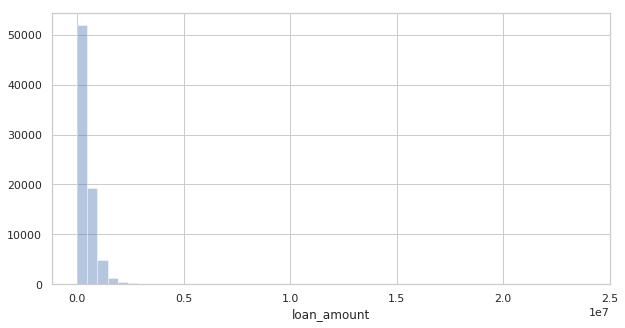

The boxplot for income is:


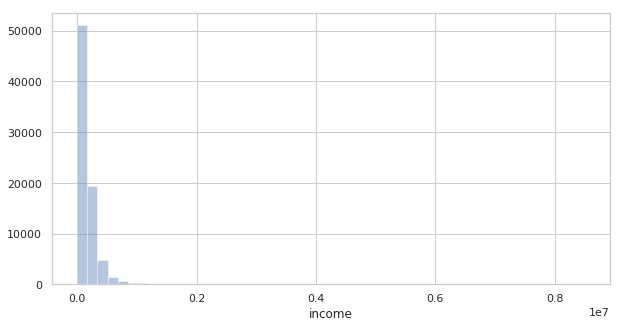

The boxplot for loan_term is:


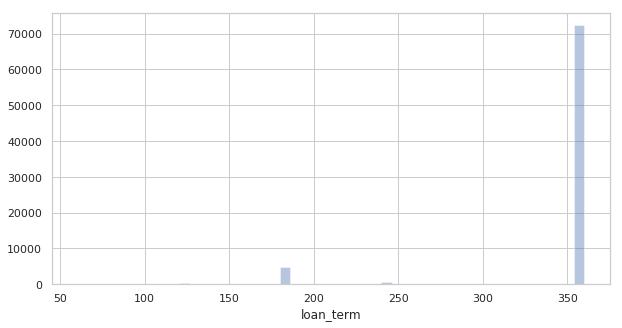

The boxplot for combined_loan-to-value_ratio is:


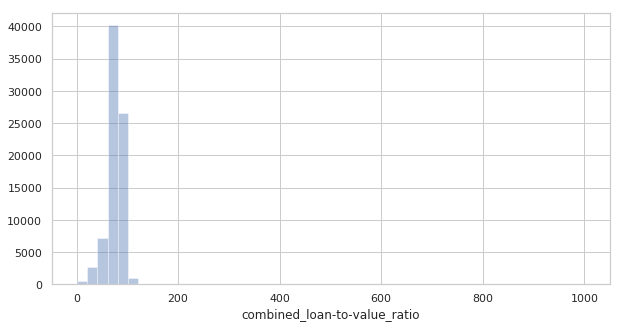

The boxplot for property_value is:


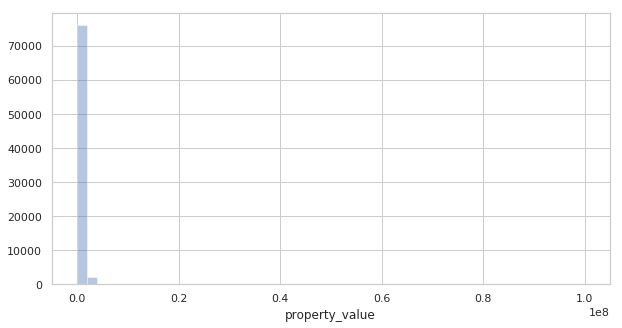

The boxplot for total_units is:


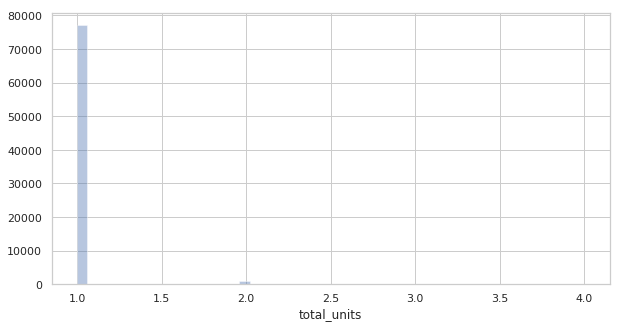

In [41]:
#check distributions of indicated variables
col_names = ['loan_amount', 'income', 'loan_term',"combined_loan-to-value_ratio", 'property_value', 'total_units']
for col in BOA[col_names]:
    print('The boxplot for {} is:'.format(col))
    sns.set(font_scale = 1, style = "whitegrid")
    plt.subplots(figsize = (10,5))
    sns.distplot(BOA[col], kde = False)
    #sns.boxplot(x = BOA_data[col], orient = 'v', width = .4, color = 'r')
    plt.show()

These are highly skewed and definitely not normal.

### 2.2 Examine correlations
To examine correlations between these continuous variables and approval rate, let's first change approval rate to a numeric target.

In [42]:
#create a new column and fill it
BOA_data['approval_rate'] = BOA_data['action_taken']
BOA_data['approval_rate'][BOA_data['approval_rate'] == 'approved'] = 1
BOA_data['approval_rate'][BOA_data['approval_rate']== 'denied'] = 0
BOA_data['approval_rate'] = BOA_data['approval_rate'].astype('int64')

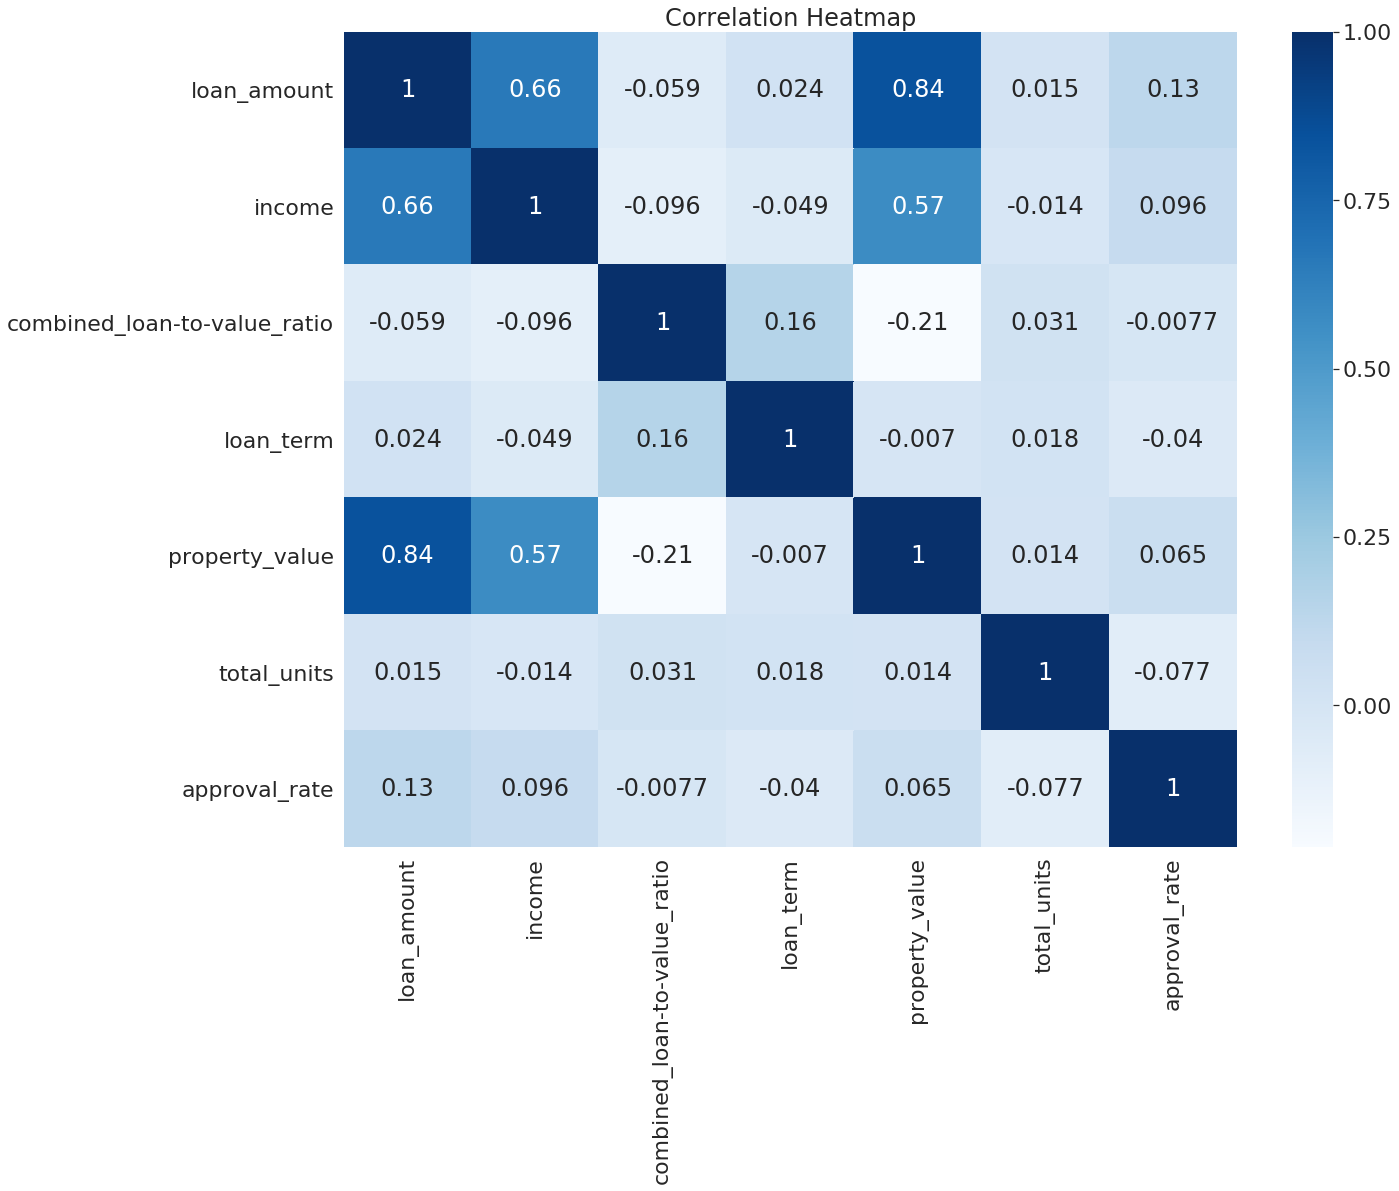

In [43]:
#correlations
sns.set(font_scale = 2)
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title('Correlation Heatmap')
corr = BOA_data.corr()
sns.heatmap(corr, xticklabels = corr.columns.values,
           yticklabels = corr.columns.values, cmap = 'Blues', annot = True, fmt = '.2g')

None of these correlations are too high to cause multicollinearity besides loan amount and property value.

### Exploratory questions:  
1) Do applicants' approval rates change across different demographics such as ethinicity, race and sex?  
2) Do applicants' income and requested loan amount change across different demographics?   

In [44]:
#write a function to plot indicated columns over targets
def plot_features(data, col_names, targets):
    for col in data[col_names]:
        for dv in targets:
            print('The comparison of {} for {}:'.format(col, dv))
            sns.set(font_scale = 1, style = "whitegrid")
            plt.subplots(figsize=(10,5))
            plt.xticks(rotation=45)
            sns.barplot(x=col, y = dv, data=data, ci = 95)
            plt.show()

The comparison of ethnicity_of_applicant for approval_rate:


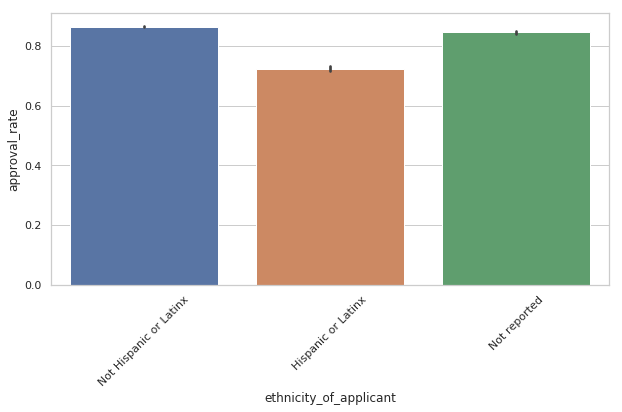

The comparison of ethnicity_of_applicant for loan_amount:


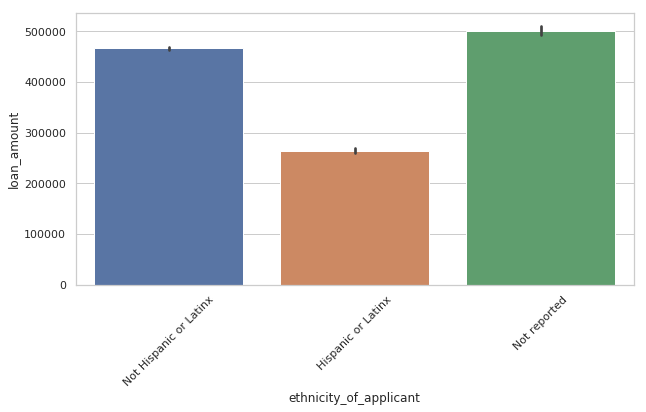

The comparison of ethnicity_of_applicant for income:


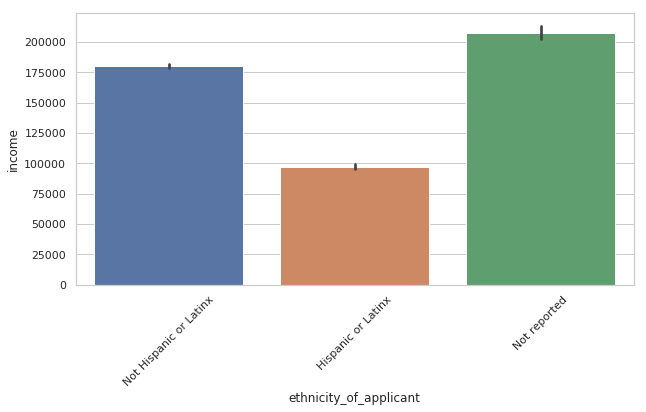

The comparison of race_of_applicant for approval_rate:


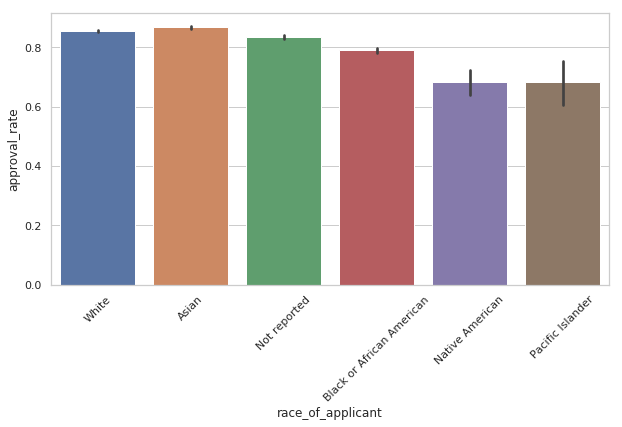

The comparison of race_of_applicant for loan_amount:


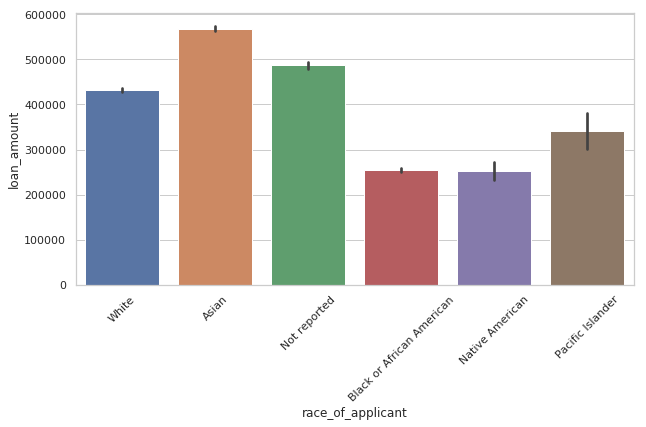

The comparison of race_of_applicant for income:


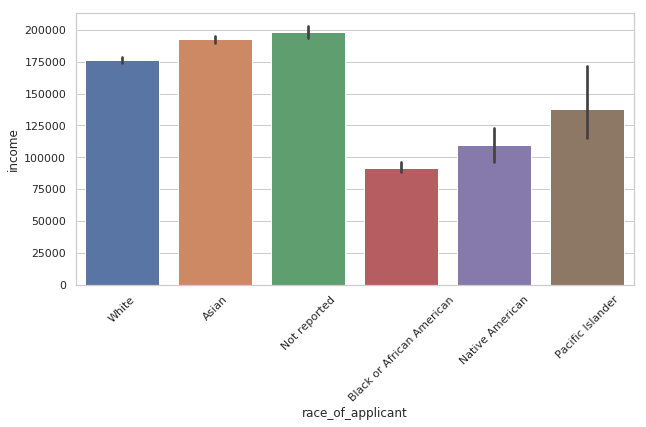

The comparison of sex_of_applicant for approval_rate:


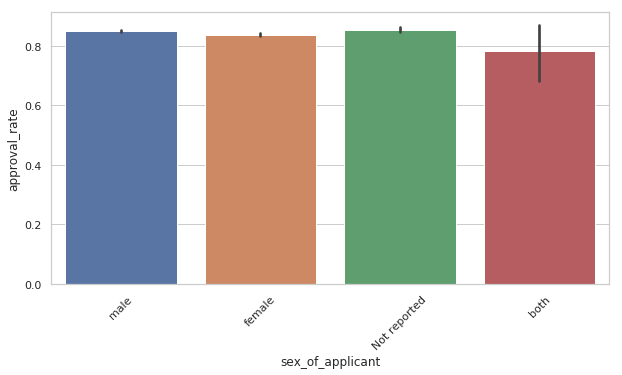

The comparison of sex_of_applicant for loan_amount:


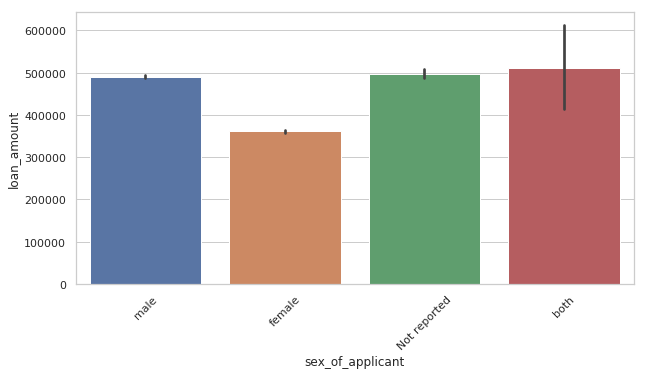

The comparison of sex_of_applicant for income:


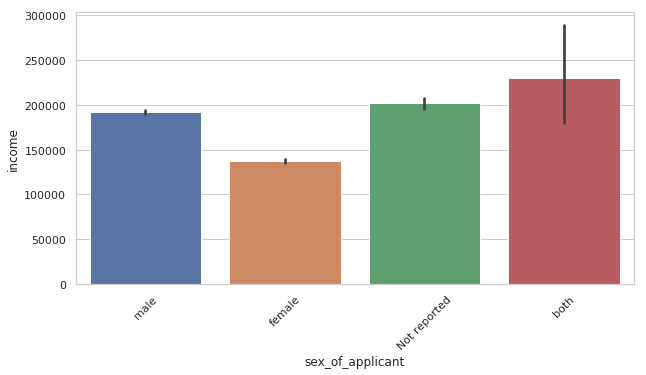

In [45]:
col_names = ['ethnicity_of_applicant', 'race_of_applicant','sex_of_applicant'] #features
targets = ['approval_rate','loan_amount' ,'income'] #targets/outcomes
plot_features(BOA_data,col_names, targets)

These results do not indicate causality nor are they modelled together to understand which feature is more important. However, these are still important insights about our data that might allow us to understand what is going on.
### 3. Machine Learning

I chose to use random forests because random forests are quite flexible in fitting complex and unbalanced data, and are not affected by non-linearity or outliers. They are also non-parametric and they do not require feature scaling. 

In [46]:
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, auc, f1_score
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from eli5.sklearn import PermutationImportance

In [47]:
#handle missing data by simple imputation
BOA = BOA_data.copy() #just in case copy your dataset
#for continuous features
imp_cont = SimpleImputer(missing_values = np.nan, strategy="median") 
#for categorical features
imp_cat = SimpleImputer(missing_values = np.nan, strategy="most_frequent")
#imputations
BOA_cat = BOA.drop(['loan_amount', 'income', 'loan_term',"combined_loan-to-value_ratio", 'property_value', 'total_units' ], axis =1)
col_names = BOA_cat.columns.tolist()
BOA_cont = BOA[['loan_amount', 'income', 'loan_term',"combined_loan-to-value_ratio", 'property_value', 'total_units' ]]
BOA_cont = imp_cont.fit_transform(BOA_cont.values)
BOA_cont = pd.DataFrame(BOA_cont, columns = ['loan_amount', 'income', 'loan_term',"combined_loan-to-value_ratio", 'property_value', 'total_units' ])
BOA_cat = imp_cat.fit_transform(BOA_cat)
BOA_cat = pd.DataFrame(BOA_cat, columns = col_names)

In [48]:
#new dataset with imputed data
BOA = pd.concat([BOA_cat, BOA_cont], axis = 1)
BOA.shape

(82110, 28)

In [49]:
#check
BOA.isna().sum()

loan_type                         0
preapproval                       0
construction_method               0
action_taken                      0
state                             0
ethnicity_of_applicant            0
ethnicity_of_co-applicant         0
race_of_applicant                 0
race_of_co-applicant              0
sex_of_applicant                  0
sex_of_co-applicant               0
age_of_applicant                  0
age_of_co-applicant               0
lien_status                       0
debt-to-income_ratio              0
balloon_payment                   0
interest-only_payments            0
negative_amortization             0
submission_of_application         0
open-end_line_of_credit           0
business_or_commercial_purpose    0
approval_rate                     0
loan_amount                       0
income                            0
loan_term                         0
combined_loan-to-value_ratio      0
property_value                    0
total_units                 

In [50]:
#split features and target as X and y
X = BOA.drop(['action_taken','approval_rate'], axis = 1)
X = pd.get_dummies(X, drop_first=True)
y = BOA.approval_rate.astype('int')
print('The shape of features is {}, the shape of the target is {}'.format(X.shape, y.shape))

The shape of features is (82110, 108), the shape of the target is (82110,)


In [51]:
#split the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)
print('The shape of X_train and X_test are {} and {}, respectively. The shapes of the training target and test target are {} and {}, respectively.'.format(X_train.shape,
    X_test.shape, y_train.shape, y_test.shape))

The shape of X_train and X_test are (57477, 108) and (24633, 108), respectively. The shapes of the training target and test target are (57477,) and (24633,), respectively.


In [52]:
#the baseline model without parameter tuning 
rfc = RandomForestClassifier(random_state=12, n_jobs = -1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
rfc_acc = accuracy_score(y_test, y_pred)
rfc_f1 = f1_score(y_test, y_pred, average="weighted")
print('The test accuracy score of the random forest is: {}, and the F1 score is: {}.'.format(rfc_acc.round(3), rfc_f1.round(3)))

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The test accuracy score of the random forest is: 0.903, and the F1 score is: 0.896.


In [53]:
#Find optimal parameters through RandomizedSearchCV
#set parameters
random_param = {
    'n_estimators': [10, 50, 100, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 50, 100, None],
    'max_features': ['auto', 'sqrt']
}

#train the model
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions=random_param, n_iter = 50, cv=10, verbose = 2, random_state = 42, n_jobs = -1)
rfc_random.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 72.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 326.5min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=10, n_jobs=-1,
                                                    oob

In [54]:
print("Best parameters for random forest are: {}, best score is: {}".format(rfc_random.best_params_, rfc_random.best_score_.round(3)))

Best parameters for random forest are: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'gini'}, best score is: 0.913


In [76]:
#Change the random forest according to the new parameters
rfc = RandomForestClassifier(random_state=12, bootstrap = True, criterion = 'gini', n_estimators = 300, max_depth = 50, max_features = 'sqrt',  n_jobs = -1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
rfc_acc = accuracy_score(y_test, y_pred)
rfc_f1 = f1_score(y_test, y_pred, average="weighted")
print('The test accuracy score of the random forest is: {}, and the F1 score is: {}.'.format(rfc_acc.round(3), rfc_f1.round(3)))

The test accuracy score of the random forest is: 0.911, and the F1 score is: 0.901.


In [77]:
#check to see whether there is too much difference between train and test accuracy
y_pred_train = rfc.predict(X_train)
rfc_acc_train = accuracy_score(y_train, y_pred_train)
rfc_f1_train = f1_score(y_train, y_pred_train, average="weighted")
print('The train accuracy score of the random forest is: {}, and the F1 score is: {}.'.format(rfc_acc_train.round(3), rfc_f1_train.round(3)))

The train accuracy score of the random forest is: 0.999, and the F1 score is: 0.999.


In [78]:
#check for specificity (recall for denied) and sensitivity (recall for approved)
print(classification_report(y_test, y_pred, target_names=['denied', 'approved']))

              precision    recall  f1-score   support

      denied       0.86      0.50      0.63      3742
    approved       0.92      0.98      0.95     20891

    accuracy                           0.91     24633
   macro avg       0.89      0.74      0.79     24633
weighted avg       0.91      0.91      0.90     24633



Recall of denied applications (specificity) is too low. We do not want a model as such because we would like to especially avoid false positives. Therefore, let's change the threshold to improve specificity.

In [83]:
#change the threshold
threshold = .75
y_pred = (rfc.predict_proba(X_test)[:, 1] >= threshold).astype('int')
rfc_acc = accuracy_score(y_test, y_pred)
rfc_f1 = f1_score(y_test, y_pred, average="weighted")
print('The test accuracy score of the random forest is: {}, and the F1 score is: {}.'.format(rfc_acc.round(3), rfc_f1.round(3)))

The test accuracy score of the random forest is: 0.883, and the F1 score is: 0.884.


We have sacrificed our accuracy a bit but let's see whether this improved our specificity:

In [82]:
#check for specificity and sensitivity
print(classification_report(y_test, y_pred, target_names=['denied', 'approved'])) #much better

              precision    recall  f1-score   support

      denied       0.61      0.63      0.62      3742
    approved       0.93      0.93      0.93     20891

    accuracy                           0.88     24633
   macro avg       0.77      0.78      0.78     24633
weighted avg       0.88      0.88      0.88     24633



In [84]:
#create a confusion matrix to demonstrate classifications
cm = confusion_matrix(y_test, y_pred)

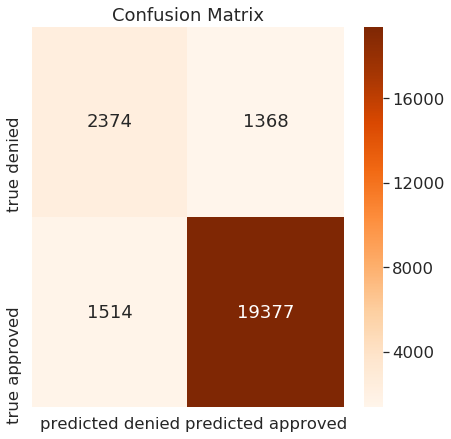

In [85]:
#visualize the confusion matrix
sns.set(font_scale = 1.5)
plt.subplots(figsize=(7,7))
ax = plt.axes()
ax.set_title('Confusion Matrix')
sns.heatmap(cm, annot = True,  xticklabels=['predicted denied', 'predicted approved'], yticklabels=['true denied', 'true approved'], cmap ='Oranges', fmt = 'g' )

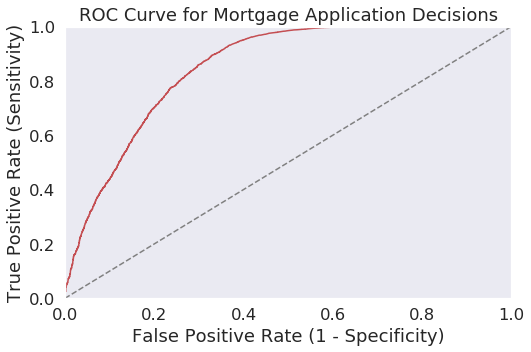

In [86]:
#the roc curve
rfc_prob = rfc.predict_proba(X_test)[:, 1]

rfc_fpr, rfc_tpr, rfc_thresholds = roc_curve(y_test, rfc_prob)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rfc_fpr, rfc_tpr, color = 'r')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".5")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC Curve for Mortgage Application Decisions')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(False)

In [87]:
#area under the curve
rfc_auc=auc(rfc_fpr, rfc_tpr)
print("Area under the curve:", rfc_auc.round(3))

Area under the curve: 0.851


In [64]:
#let's see which features are the most important in our algorithm
rand_for_perm = PermutationImportance(rfc, random_state=10).fit(X_test, y_test)

In [65]:
eli5.show_weights(rand_for_perm, feature_names=X.columns.to_list())

Weight,Feature
0.0433 ± 0.0011,debt-to-income_ratio_>60%
0.0316 ± 0.0013,debt-to-income_ratio_50%-60%
0.0314 ± 0.0013,open-end_line_of_credit_yes
0.0098 ± 0.0008,combined_loan-to-value_ratio
0.0024 ± 0.0001,loan_type_federal
0.0011 ± 0.0005,debt-to-income_ratio_36%-<50%
0.0010 ± 0.0003,debt-to-income_ratio_<20%
0.0008 ± 0.0003,preapproval_requested
0.0008 ± 0.0011,property_value
0.0007 ± 0.0002,construction_method_site-built


Redo the same analysis without applicants' (and co-applicants') demographics including ethnicity, sex, race and age:

In [88]:
#create the same dataset without demographics
BOA_without_demog = BOA.drop(BOA.columns[[5,6,7,8,9,10,11,12]], axis = 1) 
X_2 = BOA_without_demog.drop(['action_taken', 'approval_rate'], axis = 1)
X_2 = pd.get_dummies(X_2, drop_first=True)
y_2 = BOA.approval_rate.astype('int')
print('The shape of features is {}, the shape of the target is {}'.format(X_2.shape, y_2.shape))

The shape of features is (82110, 72), the shape of the target is (82110,)


In [89]:
#split the train and test data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = .30, random_state = 42)
print('The shape of X_train and X_test are {} and {}, respectively. The shapes of the training target and test target are {} and {}, respectively.'.format(X_train_2.shape,
    X_test_2.shape, y_train_2.shape, y_test_2.shape))

The shape of X_train and X_test are (57477, 72) and (24633, 72), respectively. The shapes of the training target and test target are (57477,) and (24633,), respectively.


In [90]:
#run the same machine learning algorithm without demographics
rfc.fit(X_train_2, y_train_2)
y_pred_2 = (rfc.predict_proba(X_test_2)[:, 1] >= threshold).astype('int')
rfc_acc_2 = accuracy_score(y_test_2, y_pred_2)
rfc_f1_2 = f1_score(y_test_2, y_pred_2, average="weighted")
print('The test accuracy score of the random forest is: {}, and the F1 score is: {}.'.format(rfc_acc_2.round(3), rfc_f1_2.round(3)))

The test accuracy score of the random forest is: 0.874, and the F1 score is: 0.877.


In [91]:
#check for specificity and sensitivity
print(classification_report(y_test_2, y_pred_2, target_names=['denied', 'approved']))

              precision    recall  f1-score   support

      denied       0.58      0.63      0.60      3742
    approved       0.93      0.92      0.93     20891

    accuracy                           0.87     24633
   macro avg       0.76      0.78      0.76     24633
weighted avg       0.88      0.87      0.88     24633



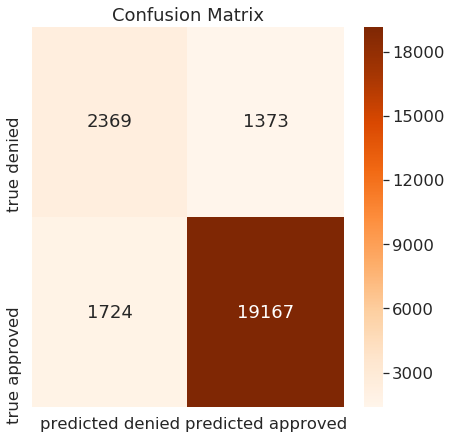

In [92]:
#visualize the confusion matrix
cm_2 = confusion_matrix(y_test_2, y_pred_2)
sns.set(font_scale = 1.5)
plt.subplots(figsize=(7,7))
ax = plt.axes()
ax.set_title('Confusion Matrix')
sns.heatmap(cm_2, annot = True,  xticklabels=['predicted denied', 'predicted approved'], yticklabels=['true denied', 'true approved'], cmap ='Oranges', fmt = 'g' )

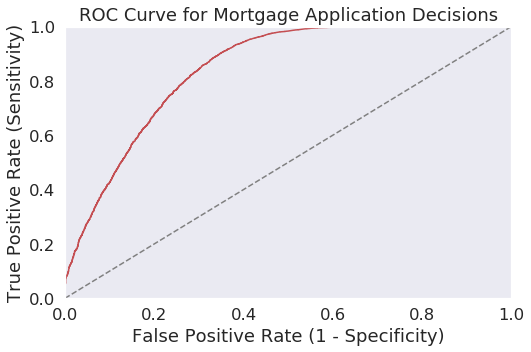

In [93]:
#roc curve
rfc_prob = rfc.predict_proba(X_test_2)[:, 1]

rfc_fpr, rfc_tpr, rfc_thresholds = roc_curve(y_test, rfc_prob)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rfc_fpr, rfc_tpr, color = 'r')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".5")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC Curve for Mortgage Application Decisions')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(False)

In [94]:
#area under the curve
rfc_auc=auc(rfc_fpr, rfc_tpr)
print("Area under the curve:", rfc_auc.round(3))

Area under the curve: 0.845


In [ ]:
#feature importance
rand_for_perm = PermutationImportance(rfc, random_state=10).fit(X_test_2, y_test_2)
eli5.show_weights(rand_for_perm, feature_names=X_2.columns.to_list())

Weight,Feature
0.0423 ± 0.0007,debt-to-income_ratio_>60%
0.0361 ± 0.0015,open-end_line_of_credit_yes
0.0315 ± 0.0017,debt-to-income_ratio_50%-60%
0.0203 ± 0.0009,combined_loan-to-value_ratio
0.0105 ± 0.0008,property_value
0.0033 ± 0.0002,submission_of_application_indirect
0.0027 ± 0.0006,lien_status_subordinate
0.0016 ± 0.0004,loan_type_federal
0.0013 ± 0.0003,preapproval_requested
0.0012 ± 0.0010,debt-to-income_ratio_36%-<50%


In [ ]:
#visualization
#extract single tree
#estimator = rfc.estimators_[20]

#from sklearn.tree import export_graphviz
#export_graphviz(estimator, out_file = 'tree.dot', class_names = ['denied', 'approved'],
#               feature_names = X_train_2.columns.tolist(), impurity = False, filled = True)

#import graphviz
#with open('tree.dot') as f:
#    dot_graph = f.read()
#graphviz.Source(dot_graph)

## IV. Results and Conclusions
* A random forest algorithm can be utilized to get the probability of mortgage approval and be useful in determining when to apply for a mortgage.
* Applicants' demographics were not as important features as applicants' finance indicators. This is not to say demographics do not affect mortgage decisions, but that a machine learning algorithm without asking for demographics can be implemented.
* The data was unbalanced with less denied decisions, and thus performed worse on those decisions. Additional data can solve this issue.
* The algorithm can be improved and generalized by including data from other banks.
* The algorithm can even be turned into a recommendation system and tell the user which aspect to improve on (assuming it is possible).